In [1]:
import HTC

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import InterpolatedUnivariateSpline
from tqdm import tqdm

# Supra-threshold avalanches

In [2]:
act = np.loadtxt('results/connectome/connectome_66_0.0_1.5_0.01_50_0.73_0_series.txt')

act, act_norm = act[:len(act)//2], act[len(act)//2:]
series = act_norm[len(act)//2]

series = act[1]

T = len(series)
t = np.arange(T)

mean = np.mean(series)
std = np.std(series)

y_star = mean + std/2

In [3]:
def hline_intersection(x1, y1, x2, y2, y_star):
    '''
    Get intersection btw lines through two points and hline
    '''
    if np.sum((y1-y2)==0)>0:
        print('hline_intersection: the y\'s are equal')
    return (x1 - x2) / (y1 - y2) * (y_star - y2) + x2

In [4]:
def get_intersection(arr, y_star):
    # Increase intersection
    start = np.where( (arr[:-1]<y_star) * (y_star<arr[1:]) )[0]
    # Decrease intersection
    stop = np.where( (arr[:-1]>y_star) * (y_star>arr[1:]) )[0]

    # Check that first start is smaller than first stop
    if start[0]>stop[0]:
        stop = np.delete(stop, 0)
    # Check that last stop is bigger than last start
    if stop[-1]<start[-1]:
        start = np.delete(start, -1)
    
    # Get intersection with hline
    start = hline_intersection(start, arr[start], start+1, arr[start+1], y_star)
    stop = hline_intersection(stop, arr[stop], stop+1, arr[stop+1], y_star)
    
    return start, stop

def get_avalanches(arr, y_star):
    start, stop = get_intersection(arr, y_star)
    
    # Compute avalanche time
    dt = stop - start
    
    # Compute avalanche size as activity area
    I = np.zeros(len(start))
    
    for i in range(len(start)):
        # Get point btw each start and stop
        t_in = t[(t>start[i])*(t<stop[i])]
        y_in = arr[t_in]
    
        # Append start and stop
        t_in = np.hstack([start[i], t_in, stop[i]])
        y_in = np.hstack([y_star, y_in, y_star])
    
        # Integrate spline
        I[i] = np.trapz(y=y_in, x=t_in)
        
    return I, dt

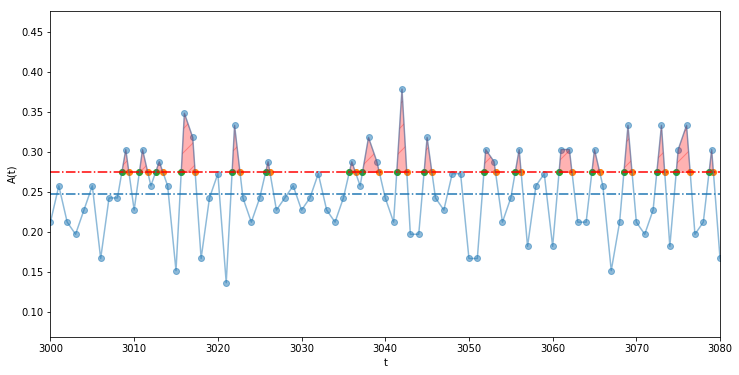

In [5]:
start, stop = get_intersection(series, y_star)

plt.figure(figsize=(12,6))

plt.plot(t, series[t], alpha=0.5)
plt.scatter(t, series[t], alpha=0.5)
plt.xlabel('t')
plt.ylabel('A(t)')

plt.scatter(stop, [y_star]*len(stop))
plt.scatter(start, [y_star]*len(start))

plt.axhline(mean, ls='-.')
plt.axhline(y_star, ls='-.', c='r')

I = []

for i in range(len(start)):
    # Get point btw each start and stop
    t_in = t[(t>start[i])*(t<stop[i])]
    y_in = series[t_in]
    
    # Append start and stop
    t_in = np.hstack([start[i], t_in, stop[i]])
    y_in = np.hstack([y_star, y_in, y_star])
    #print('t: ', t_in)
    #print('y: ', y_in)
    
    # Integrate
    I.append( np.trapz(y=y_in, x=t_in) )
    
    plt.fill(t_in, y_in, c='r', hatch='/', alpha=0.3)
    
plt.xlim([3000, 3000+80])

plt.show()

In [6]:
dt, I = [], []
dt_norm, I_norm = [], []

#run = 50
for run in tqdm(range(len(act))):
    # Define upper limit
    y_star = np.mean(act[run]) + np.std(act[run]) #/2
    
    # Get avalanche for specific run
    tmp_I, tmp_dt = get_avalanches(act[run], y_star)
    
    I.append(tmp_I)
    dt.append(tmp_dt)
    
dt = np.hstack(dt)
I = np.hstack(I)

100%|██████████| 151/151 [00:47<00:00,  3.20it/s]


In [7]:
Nbins = 50

hist_dt = np.histogram(dt, bins=Nbins)
hist_I = np.histogram(I, bins=Nbins)

hist_dt = np.array( [ (hist_dt[1][1:] + hist_dt[1][:-1])/2, hist_dt[0] ] )
hist_I = np.array( [ (hist_I[1][1:] + hist_I[1][:-1])/2, hist_I[0] ] )

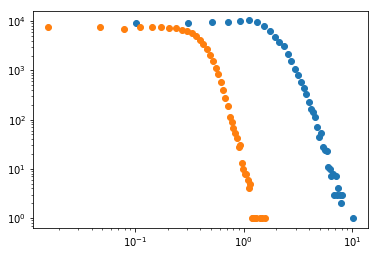

In [8]:
plt.figure()

plt.xscale('log')
plt.yscale('log')
plt.plot( hist_dt[0], hist_dt[1], 'o')
plt.plot( hist_I[0], hist_I[1], 'o')

plt.show()

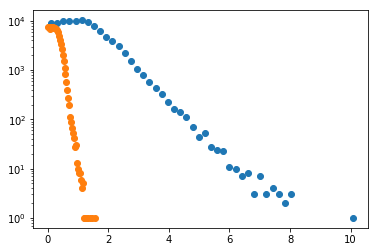

In [9]:
plt.figure()

#plt.xscale('log')
plt.yscale('log')
plt.plot( hist_dt[0], hist_dt[1], 'o')
plt.plot( hist_I[0], hist_I[1], 'o')

plt.show()

# Causal Avalanches

In [9]:
from numba import jit, prange

import numpy as np
import matplotlib.pyplot as plt

In [10]:
@jit(nopython=True)
def update_state_single(S, W, T, r1, r2, aval, step, avalOn):
    '''
    Update state of the system according to HTC model
    Update causal avalanches state
    '''
    N = len(S)
    probs = np.random.random(N)                 # generate probabilities
    s = (S==1).astype(np.float64)               # get active nodes
    pA = ( r1 + (1.-r1) * ( (W@s)>T ) )         # prob. to become active

    # update state vector
    newS = ( (S==0)*(probs<pA)                  # I->A
         + (S==1)*-1                            # A->R
         + (S==-1)*(probs>r2)*-1 )              # R->I (remain R with prob 1-r2)
    
    # Causal avalanches
    newAval = np.zeros(N) #-1
    if avalOn:        
        p_single_neuron = W*s / (W@s).reshape(-1,1) * (1.-r1)  # prob of single neuron to be activated
        
        # Loop over nodes
        for node in prange(N):
            # Check if new activation
            if newS[node] == 1:
                p_cum = np.cumsum(p_single_neuron[node])    # cumsum
                causal = np.where(p_cum>probs[node])[0]
                
                if len(causal)>0:
                    # Activated by another neuron
                    newAval[node] = aval[causal[0]]
                else:
                    # Self-activation
                    newAval[node] = 10 +  step*N + node

    return newS, newAval

@jit(nopython=True)
def update_state(S, W, T, r1, r2, aval, step, avalOn=True):
    '''
    Update state of each runs
    '''
    runs = S.shape[0]
    newS = np.zeros((S.shape[0], S.shape[1]), dtype=np.float64)
    newAval = np.zeros((S.shape[0], S.shape[1]), dtype=np.int32)
    
    # Simulation step in parallel
    for i in prange(runs):
        tmpS = update_state_single(S[i], W, T, r1, r2, aval[i], step, avalOn)
        newS[i] = tmpS[0]
        newAval[i] = tmpS[1]
        
    return (newS, (newS==1).astype(np.int64), newAval)

In [11]:
N = 66
runs = 50
steps = 6000

r1 = 2 / N
r2 = r1**(1/5)
T = r2 / (1. + 2.*r2)
#T = 0.01

W = np.random.random((N, N))

S0 = np.random.randint(-1,2, (runs, N))
s0 = (S0==1).astype(int)

aval0 = (S0==1) * np.arange(1,N+1)
aval0 = aval0.astype(np.int32)

In [12]:
S = np.zeros((steps, runs, N))
aval = np.zeros((steps, runs, N))
S[0] = S0
aval[0] = aval0

for i in range(1,steps):
    S[i], s, aval[i] = update_state(S[i-1], W, T, r1, r2, aval[i-1], i)

In [13]:
tt = aval[:,0] # get run 0
ss = S[:,0]

In [14]:
@jit(nopython=True)
def getCausalAval(aval):
    '''
    Return the time series of each avalanche for a single run
    '''
    steps, N = aval.shape
    names = np.unique(aval)                 # get the code of each avalanche
    names = np.delete(names, 0)             # remove elements 0 i.e. not active
    
    series = np.zeros((len(names), steps))  # init time series of each avalanche
    
    for step in prange(steps):
        now_active = np.unique(aval[step])  # get code of aval active at time t
        now_active = np.delete(now_active, 0) # remove elements 0 i.e. not active
        
        for code in now_active:
            count = np.count_nonzero(aval[step]==code) # count aval size
            index = np.where(names == code)[0]         # get aval name index
            series[index, step] = count
    
    return series / N

In [15]:
@jit(nopython=True)
def getCausalAvalPdf(aval):
    '''
    Return size and time pdf of causal avalanches.
    '''
    steps, runs, N = aval.shape
    
    sizes = []
    times = []
    
    # Loop over runs
    for i in prange(runs):
        series = getCausalAval(aval[:,i]) # get time series of avalanches
        # Loop over avals
        for j in range(len(series)):
            sizes.append(series[j].sum()) # size as integral of single avalanche
            ts = np.where(series[j]>0)[0]    # get times where avalanche is active
            times.append(ts[-1]-ts[0])
            
    return sizes, times

In [16]:
aval_series = getCausalAval(tt)

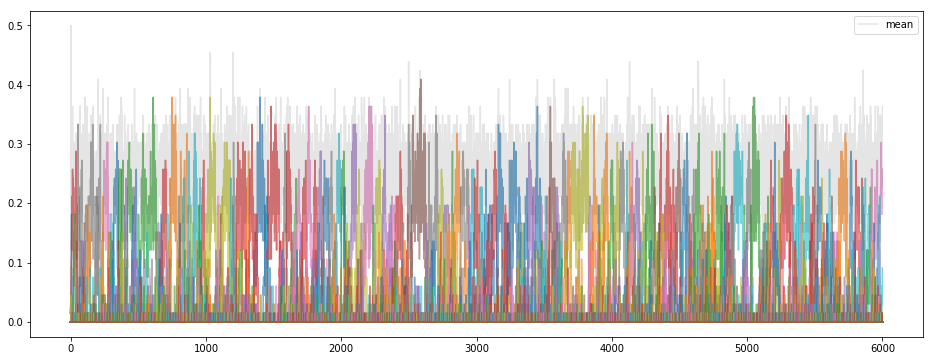

In [17]:
plt.figure(figsize=(16,6))
for i in range(len(aval_series)):
    plt.plot(aval_series[i], alpha=0.6)
plt.plot(np.mean(ss>0,axis=1), c='k', alpha=0.1, label='mean')
plt.legend()
plt.show()

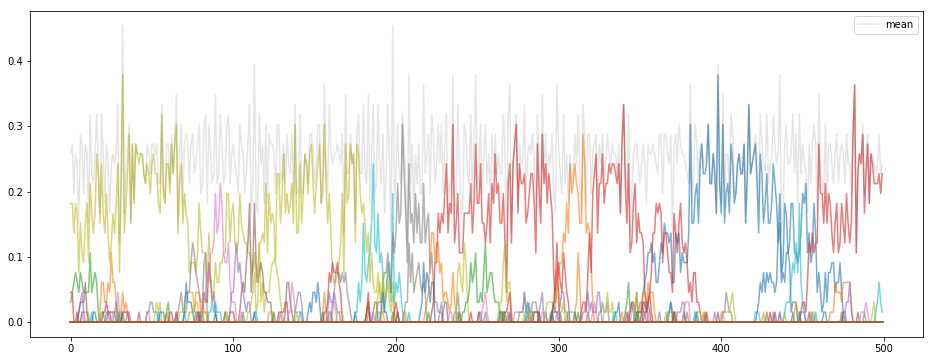

In [25]:
T = 500

plt.figure(figsize=(16,6))
for i in range(len(aval_series)):
    plt.plot(aval_series[i][1000:1000+T], alpha=0.6)
plt.plot(np.mean(ss>0,axis=1)[1000:1000+T], c='k', alpha=0.1, label='mean')
plt.legend()
plt.show()

In [20]:
sizes, times = getCausalAvalPdf(aval)

In [21]:
size_hist = np.histogram(sizes, bins=15, density=True)
size_hist = np.array([ (size_hist[1][1:]+size_hist[1][:-1])/2, size_hist[0] ])

time_hist = np.histogram(times, bins=15, density=True)
time_hist = np.array([ (time_hist[1][1:]+time_hist[1][:-1])/2, time_hist[0] ])

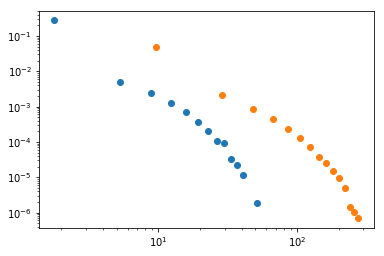

In [22]:
plt.figure()

plt.xscale('log')
plt.yscale('log')

plt.plot(size_hist[0], size_hist[1], 'o')
plt.plot(time_hist[0], time_hist[1], 'o')

plt.show()

In [ ]:
size_hist[0]

In [ ]:
# ---------- CAUSAL AVALANCHES ----------
@jit(nopython=True)
def get_causal_avalanches(aval):
    '''
    Return the time series of each avalanche for a single run
    '''
    steps, N = aval.shape
    names = np.unique(aval)                 # get the code of each avalanche
    names = np.delete(names, 0)             # remove elements 0 i.e. not active
    
    series = np.zeros((len(names), steps))  # init time series of each avalanche
    
    for step in prange(steps):
        now_active = np.unique(aval[step])  # get code of aval active at time t
        now_active = np.delete(now_active, 0) # remove elements 0 i.e. not active
        
        for code in now_active:
            count = np.count_nonzero(aval[step]==code) # count aval size
            index = np.where(names == code)[0]         # get aval name index
            series[index, step] = count
    
    return series / N


@jit(nopython=True)
def get_causal_avalanches_pdf(aval, Nbins=50):
    '''
    Return size and time pdf of causal avalanches.
    '''
    steps, runs, N = aval.shape
    
    sizes = np.array([0.0])
    times = np.array([0])
    
    # Loop over runs
    for i in prange(runs):
        series = get_causal_avalanches(aval[:,i])    # get time series of avalanches
        # Loop over avals
        for j in range(len(series)):
            size = np.array(series[j].sum()).reshape(1)
            sizes = np.hstack(( sizes, size ))    # size as integral of single avalanche
            ts = np.where(series[j]>0)[0]    # get times where avalanche is active
            ts = np.array(ts[-1]-ts[0]).reshape(1)
            times = np.hstack((times, ts))
    
    # Remove fake 0 as first element
    sizes = np.delete(sizes, 0)
    times = np.delete(times, 0)
    
    # Get histograms to compress data
    hist_size = np.histogram(sizes, bins = Nbins)
    hist_time = np.histogram(times, bins = Nbins)
            
    # Convert bin edges to bin center
    hist_size = np.vstack( ( (hist_size[1][1:] + hist_size[1][:-1])/2, hist_size[0] ) )
    hist_time = np.vstack( ( (hist_time[1][1:] + hist_time[1][:-1])/2, hist_time[0] ) )
    
    return hist_size, hist_time

In [ ]:
hist_size, hist_time = get_causal_avalanches_pdf(aval)

In [ ]:
plt.figure()

plt.xscale('log')
plt.yscale('log')

plt.plot(hist_size[0], hist_size[1] / sum(hist_size[1]), 'o')
plt.plot(hist_time[0], hist_time[1] / sum(hist_time[1]), 'o')

plt.show()